Logistic Regression: Feature Re-scaling
===

A quick demonstration of the impact of feature rescaling on the decision boundary learned via logistic regression.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.transforms as transforms

import sklearn
import sklearn.linear_model

import scipy.stats
from scipy.stats import multivariate_normal

import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import display, Math

In [2]:
# Not-my-code to draw an ellipse at the given stddev for a 2d gaussian distribution
# Source: https://matplotlib.org/3.1.0/gallery/statistics/confidence_ellipse.html
def get_ci_ellipse(mean, cov, ax, n_std=3.0, edgecolor='black', facecolor='none'):
    mean_x, mean_y = mean
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = matplotlib.patches.Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor, edgecolor=edgecolor)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [14]:
# Define generating distributions
# which are two gaussians with different covariances
mean0 = [4, 2]
cov0 = np.array([[12.0, 0.3], 
                 [0.3, 0.25]])
rv0 = multivariate_normal(mean0, cov0)
mean1 = [10, 4]
cov1 = np.array([[1.0, 0.4], 
                 [0.4, 1.2]])
rv1 = multivariate_normal(mean1, cov1)

<IPython.core.display.Math object>

Optimization terminated successfully.
         Current function value: 0.204289
         Iterations 8


<IPython.core.display.Math object>

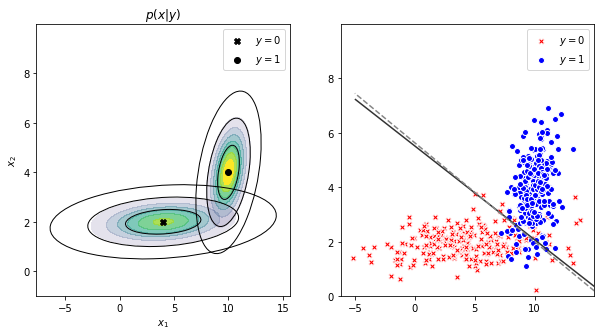

In [15]:
# Plot the underlying distributions
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes[0]
x, y = np.mgrid[-5:12:.01, -1:10:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
contour_colors = [matplotlib.cm.viridis(i, alpha=i) for i in np.linspace(0, 1, 8)]
ax.contourf(x, y, rv0.pdf(pos), colors=contour_colors)
ax.contourf(x, y, rv1.pdf(pos), colors=contour_colors)
for n_std in [1, 2, 3]:
    ellipse = get_ci_ellipse(mean0, cov0, ax, n_std=n_std, facecolor='none')
for n_std in [1, 2, 3]:
    ellipse = get_ci_ellipse(mean1, cov1, ax, n_std=n_std, facecolor='none')
ax.scatter(mean0[0], mean0[1], marker='X', facecolor='black', label='$y=0$')
ax.scatter(mean1[0], mean1[1], marker='o', facecolor='black', label='$y=1$')
ax.set_title("$p(x|y)$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend()

p_y0 = 0.5  # p(y = 0) i.e. the percentage of class 0 vs 1 points
p_y1 = 0.5
display(Math(r'p(y=0) = {} \\ p(y=1) = {} \\'.format(p_y0, p_y1)))
n = 500

# Draw n data points from the two disributions to use as training data
y0_count = int(n * p_y0)
y1_count = int(n * p_y1)
y0_pts = rv0.rvs(size=y0_count)
y1_pts = rv1.rvs(size=y1_count)
X_no_bias = np.concatenate((y0_pts, y1_pts), axis=0)
X = sklearn.preprocessing.add_dummy_feature(X_no_bias)
y = np.array([0] * y0_count + [1] * y1_count)

# Fit a logistic regression model to the data
md = sm.Logit(endog=y, exog=X).fit()
y_pred = md.predict(X) >= 0.5
y_train_acc = sklearn.metrics.accuracy_score(y, y_pred)
display(Math(r'\text{Train accuracy: } %.3f ' % y_train_acc))

# Plot the data, along with the decision boundary learned by the logit model
ax = axes[1]
X_y0 = X[y == 0]
X_y1 = X[y == 1]
ax.scatter(X_y0.T[1], X_y0.T[2], marker='X', color='white', facecolor='red', label='$y=0$')
ax.scatter(X_y1.T[1], X_y1.T[2], marker='o', color='white', facecolor='blue', label='$y=1$')
xx, yy = np.mgrid[-5:15:.01, 0:10:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
grid_with_bias = sklearn.preprocessing.add_dummy_feature(grid)
probs = md.predict(grid_with_bias).reshape(xx.shape)
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)  # I borrowed this grid approach to drawing the decision boundary from a SO post

# for comparison, also plot the "optimal" linear decision boundary as a dashed line
# rather than compute the optimal boundary directly, we cheat and approximate with a much larger sample size
n_train_optimal = 100000
train_y0_count_optimal = int(n_train_optimal * p_y0)
train_y1_count_optimal = int(n_train_optimal * p_y1)
train_y0_pts_optimal = rv0.rvs(size=train_y0_count_optimal)
train_y1_pts_optimal = rv1.rvs(size=train_y1_count_optimal)
X_train_optimal = np.concatenate((train_y0_pts_optimal, train_y1_pts_optimal), axis=0)
y_train_optimal = np.array([0] * train_y0_count_optimal + [1] * train_y1_count_optimal)
clf_optimal = sklearn.linear_model.LogisticRegression(solver='lbfgs', penalty='none')
clf_optimal.fit(X_train_optimal, y_train_optimal)
probs_optimal = clf_optimal.predict_proba(grid)[:, 1].reshape(xx.shape)
ax.contour(xx, yy, probs_optimal, levels=[.5], cmap="Greys", vmin=0, vmax=.9, linestyles='dashed')
ax.legend()

plt.plot()
None

In [16]:
# normalize by scaling to mean 0, stddev 1
X_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X_no_bias)
np.mean(X_scaled, axis=0), np.std(X_scaled, axis=0)

(array([ 8.39994740e-16, -1.54454227e-15]), array([1., 1.]))

In [17]:
# Correlation of x1 and x2 is relatively modest, and rescaling doesn't change the correlation
X_corr, _ = scipy.stats.pearsonr(X_no_bias[:,0], X_no_bias[:,1])
X_corr_scaled, _ = scipy.stats.pearsonr(X_scaled[:,0], X_scaled[:,1])
assert np.isclose(X_corr, X_corr_scaled, atol=1e20)  # rescaling doesn't change the correlation!
X_corr, X_corr_scaled

(0.6155152424242505, 0.6155152424242505)

In [18]:
# for comparison, also normalize each row independently using the l2 norm
X_normed = sklearn.preprocessing.normalize(X_no_bias, norm='l2')
np.mean(X_normed,), np.std(X_normed)

(0.6125655674011918, 0.3532186654672369)

In [19]:
# since we're using statsmodels, also need to manually add the intercept term
X_scaled = sklearn.preprocessing.add_dummy_feature(X_scaled)
X_normed = sklearn.preprocessing.add_dummy_feature(X_normed)

Optimization terminated successfully.
         Current function value: 0.204289
         Iterations 8


<IPython.core.display.Math object>

Optimization terminated successfully.
         Current function value: 0.204289
         Iterations 8


<IPython.core.display.Math object>

Optimization terminated successfully.
         Current function value: 0.521670
         Iterations 12


<IPython.core.display.Math object>

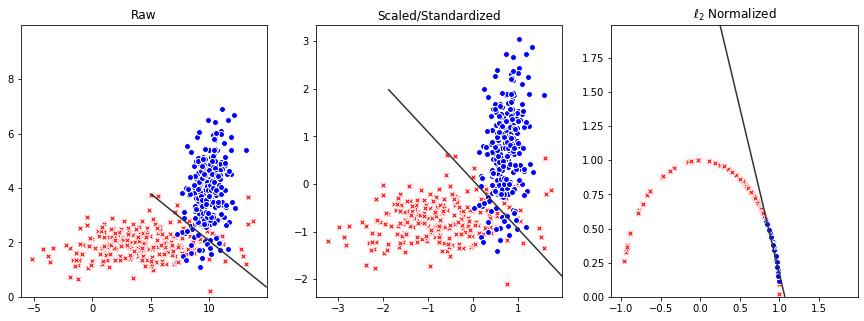

In [25]:
# now, we make a plot to compare the two types of normalization used
fig, axes = plt.subplots(1,3,figsize=(15,5))

# un-normalized data
md = sm.Logit(endog=y, exog=X).fit()
y_pred = md.predict(X) >= 0.5
y_train_acc = sklearn.metrics.accuracy_score(y, y_pred)
display(Math(r'\text{Raw train accuracy: } %.3f ' % y_train_acc))
ax = axes[0]
X_y0 = X[y == 0]
X_y1 = X[y == 1]
ax.scatter(X_y0.T[1], X_y0.T[2], marker='X', color='white', facecolor='red', label='$y=0$')
ax.scatter(X_y1.T[1], X_y1.T[2], marker='o', color='white', facecolor='blue', label='$y=1$')
xx, yy = np.mgrid[5:15:.01, 0:10:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
grid = sklearn.preprocessing.add_dummy_feature(grid)
probs = md.predict(grid).reshape(xx.shape)
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax.set_title("Raw")
y_pred_raw = y_pred

# scaled/standardized data
md_scaled = sm.Logit(endog=y, exog=X_scaled).fit()
y_pred = md_scaled.predict(X_scaled) >= 0.5
y_train_acc = sklearn.metrics.accuracy_score(y, y_pred)
display(Math(r'\text{Scaled train accuracy: } %.3f ' % y_train_acc))
ax = axes[1]
X_y0 = X_scaled[y == 0]
X_y1 = X_scaled[y == 1]
ax.scatter(X_y0.T[1], X_y0.T[2], marker='X', color='white', facecolor='red', label='$y=0$')
ax.scatter(X_y1.T[1], X_y1.T[2], marker='o', color='white', facecolor='blue', label='$y=1$')
xx, yy = np.mgrid[-2:2:.01, -2:2:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
grid = sklearn.preprocessing.add_dummy_feature(grid)
probs = md_scaled.predict(grid).reshape(xx.shape)
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax.set_title("Scaled/Standardized")
y_pred_scaled = y_pred

# l2-normalized data
md_normed = sm.Logit(endog=y, exog=X_normed).fit()
y_pred = md_normed.predict(X_normed) >= 0.5
y_train_acc = sklearn.metrics.accuracy_score(y, y_pred)
display(Math(r'\text{Normed train accuracy: } %.3f ' % y_train_acc))
ax = axes[2]
X_y0 = X_normed[y == 0]
X_y1 = X_normed[y == 1]
ax.scatter(X_y0.T[1], X_y0.T[2], marker='X', color='white', facecolor='red', label='$y=0$')
ax.scatter(X_y1.T[1], X_y1.T[2], marker='o', color='white', facecolor='blue', label='$y=1$')
xx, yy = np.mgrid[0:2:.01, 0:2:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
grid = sklearn.preprocessing.add_dummy_feature(grid)
probs = md_normed.predict(grid).reshape(xx.shape)
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax.set_title("$\ell_2$ Normalized")

plt.plot()
None

In [21]:
# an identical decision boundary is learned between the scaled and unscaled data!
assert np.all(y_pred_raw == y_pred_scaled)

In [22]:
# Summary of the model fit on the raw data
md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                          Logit   Df Residuals:                      497
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Jan 2020   Pseudo R-squ.:                  0.7053
Time:                        11:55:40   Log-Likelihood:                -102.14
converged:                       True   LL-Null:                       -346.57
Covariance Type:            nonrobust   LLR p-value:                7.012e-107
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7715      1.074    -10.031      0.000     -12.876      -8.667
x1             0.6731      0.094      7.134      0.000       0.488       0.858
x2             1.9530      0.255      7.662      0.000       1.453       2.453
==============================================================================
"""

In [23]:
# Summary of the scaled model
# Note: only the coefficients and the intercept are different!
md_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                          Logit   Df Residuals:                      497
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Jan 2020   Pseudo R-squ.:                  0.7053
Time:                        11:55:41   Log-Likelihood:                -102.14
converged:                       True   LL-Null:                       -346.57
Covariance Type:            nonrobust   LLR p-value:                7.012e-107
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2006      0.250     -0.804      0.422      -0.690       0.289
x1             2.5754      0.361      7.134      0.000       1.868       3.283
x2             2.5399      0.331      7.662      0.000       1.890       3.190
==============================================================================
"""

In [13]:
# the ratio of parameter to standard error is the same!
# thus, rescaling DOES NOT decrease the impact of colinearity
standard_error_ratio = md.params / md.bse
standard_error_ratio_scaled = md_scaled.params / md_scaled.bse
assert np.all(np.isclose(standard_error_ratio[1:], standard_error_ratio_scaled[1:]))